# This code is not functional as it uses a different version of lymph!

In [3]:
import numpy as np
import lymph
import pandas as pd
import scipy as sp
from scipy.special import factorial
import matplotlib.pyplot as plt
import emcee                      # inference and backends for sample storage
from multiprocessing import Pool  # for parallelization of the inference
import lymph

# dataset_full_CLB = pd.read_csv("data/2021-clb-oropharynx.csv", header=[0,1,2]) #import data
# stage_CLB = pd.DataFrame(dataset_full_CLB['tumor']['1']['t_stage'])
# header_stage = pd.MultiIndex.from_product([['tumor'], ['1'], ['t_stage']], names=['', '', ''])
# stage_CLB.columns = header_stage
# midline = pd.DataFrame(dataset_full_CLB['tumor']['1']['extension'])
# header_midline = pd.MultiIndex.from_product([['tumor'], ['1'], ['extension']], names=['', '', ''])
# midline.columns = header_midline
# clinical_ipsi = dataset_full_CLB['diagnostic_consensus']['ipsi'].drop(['Ia','Ib','V','VII'],axis = 1) 
# patho_ipsi = dataset_full_CLB['pathology']['ipsi'].drop(['Ia','Ib','V','VII'],axis = 1) 
# header1 = pd.MultiIndex.from_product([['pathological'], ['ipsi'], ['II', 'III', 'IV']], names=['', '', ''])
# header2 = pd.MultiIndex.from_product([['clinical_consensus'],['ipsi'], ['II', 'III', 'IV']], names=['', '', ''])
# patho_ipsi.columns = header1
# clinical_ipsi.columns = header2
# clinical_contra = dataset_full_CLB['diagnostic_consensus']['contra'].drop(['Ia','Ib','V','VII'],axis = 1) 
# patho_contra = dataset_full_CLB['pathology']['contra'].drop(['Ia','Ib','V','VII'],axis = 1) 
# header1 = pd.MultiIndex.from_product([['pathological'], ['contra'], ['II', 'III', 'IV']], names=['', '', ''])
# header2 = pd.MultiIndex.from_product([['clinical_consensus'],['contra'], ['II', 'III', 'IV']], names=['', '', ''])
# patho_contra.columns = header1
# clinical_contra.columns = header2
# dataset_CLB = pd.concat([stage_CLB,midline,clinical_ipsi,clinical_contra,patho_ipsi,patho_contra],axis = 1) #concatenate the information
# dataset_CLB
new_dataset = pd.read_csv("../lynference/data/enhanced_trial.csv", header=[0,1,2]) #import data
new_dataset = new_dataset.drop(['Unnamed: 0_level_0'],axis = 1)
new_dataset

/tmp/ipykernel_650721/47952858.py:33: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_dataset = new_dataset.drop(['Unnamed: 0_level_0'],axis = 1)


patient                                                                    \
          #                                                                     
         id     sex age diagnose_date alcohol_abuse nicotine_abuse hpv_status   
0         1    male  59    30/08/2017          True           True       True   
1         2  female  75    25/10/2017         False          False       True   
2         3    male  87    03/04/2018         False           True       True   
3         4    male  87    16/04/2018          True           True      False   
4         5  female  70    25/05/2018          True           True       True   
..      ...     ...  ..           ...           ...            ...        ...   
593   BE601  female  53    2012-12-22          True           True       True   
594   BE604    male  70    2011-08-04         False           True       True   
595   BE605    male  75    2011-05-13         False           True       True   
596   BE621  female  47    2011-10-19         False           True       True   
597   BE624    male  38    2013-09-16         False          False       True   

                                         ... max_llh                       \
                                         ...  contra                        
    neck_dissection tnm_edition n_stage  ...     IIa      I    VII     Vb   
0             False           8       1  ...   False  False  False    NaN   
1             False           8       1  ...    True  False  False    NaN   
2             False           7       2  ...    True   True  False    NaN   
3             False           8       3  ...   False  False  False    NaN   
4             False           7       2  ...   False  False  False    NaN   
..              ...         ...     ...  ...     ...    ...    ...    ...   
593            True           7       1  ...   False  False    NaN  False   
594            True           7       0  ...   False  False    NaN  False   
595            True           7       2  ...   False  False    NaN  False   
596            True           7       2  ...   False  False    NaN  False   
597            True           7       2  ...   False  False    NaN  False   

                             diagnostic_consensus         
                                             ipsi contra  
        II  VI     Ia     Va                    I      I  
0    False NaN  False    NaN                  NaN    NaN  
1     True NaN  False    NaN                  NaN    NaN  
2     True NaN  False    NaN                  NaN    NaN  
3    False NaN  False    NaN                  NaN    NaN  
4    False NaN  False    NaN                  NaN    NaN  
..     ...  ..    ...    ...                  ...    ...  
593  False NaN  False  False                  NaN    NaN  
594  False NaN  False  False                  NaN    NaN  
595  False NaN  False  False                  NaN    NaN  
596  False NaN  False  False                  NaN    NaN  
597  False NaN  False  False                  NaN    NaN  

[598 rows x 353 columns]

In [4]:
graph = {
    ('tumor', 'primary')  : ['I','II', 'III', 'IV','V','VII'], 
    ('lnl'  , 'I') :       ['II'],
    ('lnl'  , 'II') :       ['III'], 
    ('lnl'  , 'III'):       ['IV'], 
    ('lnl'  , 'IV') :       ['V'],
    ('lnl'  , 'V') :       [],
    ('lnl'  , 'VII') :       []
    
}
model = lymph.models.Midline(graph_dict= graph,tumor_state = 1, unilateral_kwargs={'allowed_states':[0,1], 'max_time':10})
model.modalities['max_llh'] = lymph.modalities.Pathological(specificity = 1,sensitivity = 1,is_trinary=True)
model.load_patient_data(new_dataset)

AttributeError: module 'lymph' has no attribute 'models'

In [3]:
# Time prior with p(early) = 0.3
def binom_pmf(k: np.ndarray, n: int, p: float):
    """Binomial PMF"""
    if p > 1. or p < 0.:
        raise ValueError("Binomial prob must be btw. 0 and 1")
    q = (1. - p)
    binom_coeff = factorial(n) / (factorial(k) * factorial(n - k))
    return binom_coeff * p**k * q**(n - k)

def late_binomial(support: np.ndarray, p: float = 0.5) -> np.ndarray:
    """Parametrized binomial distribution."""
    return binom_pmf(support, n=support[-1], p=p)

max_t = 10
model.ext.diag_time_dists["early"] = sp.stats.binom.pmf(np.arange(max_t+1), max_t, 0.3)
model.ext.diag_time_dists["late"] = late_binomial
model.noext.diag_time_dists["early"] = sp.stats.binom.pmf(np.arange(max_t+1), max_t, 0.3)
model.noext.diag_time_dists["late"] = late_binomial

In [4]:
starting_points = {'ipsi_primary_to_I_spread': 0.1,
                   'ipsi_primary_to_II_spread': 0.3,
                   'ipsi_primary_to_III_spread': 0.2,
                   'ipsi_primary_to_IV_spread': 0.2,
                   'ipsi_primary_to_V_spread': 0.08,
                   'ipsi_primary_to_VII_spread': 0.09,
                   'contra_primary_to_I_spread': 0.04,
                   'contra_primary_to_II_spread': 0.1,
                   'contra_primary_to_III_spread': 0.03,
                   'contra_primary_to_IV_spread': 0.05,    
                   'contra_primary_to_V_spread': 0.05,                   
                   'contra_primary_to_VII_spread': 0.05,   
                   'I_to_II_spread': 0.18,
                   'II_to_III_spread': 0.19,
                   'III_to_IV_spread': 0.18,
                   'IV_to_V_spread': 0.18,
                   'late_p': 0.5,
                   'mixing': 0.5}
model.assign_params(**starting_points)

model.likelihood(mode = 'HMM')


-2664.2796902655805

In [5]:
backend = emcee.backends.HDFBackend(filename = "trial_samples", name = 'tester')
model.get_params()

{'ipsi': {'primary_to_I_spread': 0.1,
  'primary_to_II_spread': 0.3,
  'primary_to_III_spread': 0.2,
  'primary_to_IV_spread': 0.2,
  'primary_to_V_spread': 0.08,
  'primary_to_VII_spread': 0.09,
  'I_to_II_spread': 0.18,
  'II_to_III_spread': 0.19,
  'III_to_IV_spread': 0.18,
  'IV_to_V_spread': 0.18,
  'late_p': 0.5},
 'no extension contra': {'primary_to_I_spread': 0.04,
  'primary_to_II_spread': 0.1,
  'primary_to_III_spread': 0.03,
  'primary_to_IV_spread': 0.05,
  'primary_to_V_spread': 0.05,
  'primary_to_VII_spread': 0.05,
  'I_to_II_spread': 0.18,
  'II_to_III_spread': 0.19,
  'III_to_IV_spread': 0.18,
  'IV_to_V_spread': 0.18,
  'late_p': 0.5},
 'mixing': 0.5}

In [6]:
new_acor = backend.get_autocorr_time(tol = 0)
np.mean(new_acor)

449.1449386275129

burn-in: 4000
thin: 1000
flat chain shape: (2160, 18)
(16000, 180, 18)


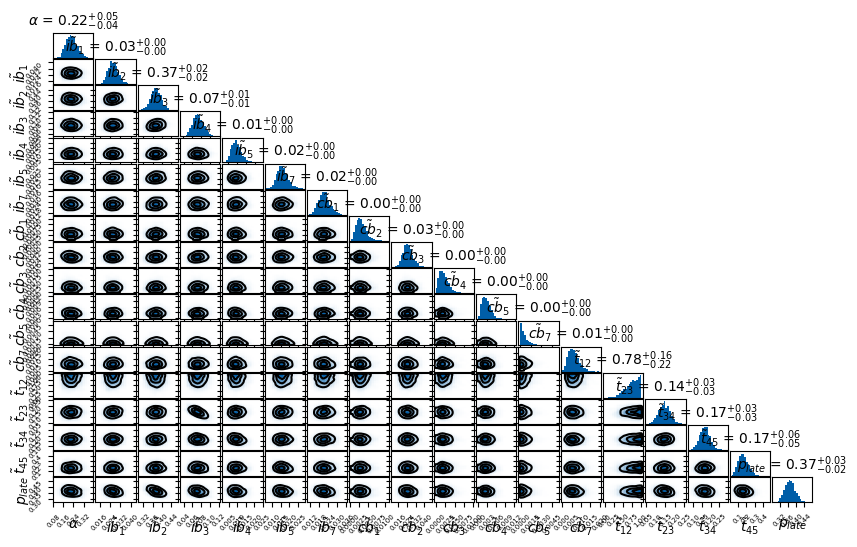

In [7]:
tau = 2000
burnin = int(2 * np.max(tau))
thin = int(0.5 * np.min(tau))
samples1 = backend.get_chain(discard=burnin, flat=True, thin=thin)
print("burn-in: {0}".format(burnin))
print("thin: {0}".format(thin))
print("flat chain shape: {0}".format(samples1.shape))

# reader = emcee.backends.HDFBackend(filename = samples.hdf5, name= 'original/samples')
# reader.shape
print(backend.get_chain().shape)
# ar = np.mean(original_sampler.acceptance_fraction)
# print(f"the HMM sampler accepted {ar * 100 :.2f} % of samples.")

import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
from matplotlib import font_manager
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import ListedColormap
from cycler import cycler
import corner

# USZ colors
usz_blue = '#005ea8'
usz_green = '#00afa5'
usz_red = '#ae0060'
usz_orange = '#f17900'
usz_gray = '#c5d5db'

# colormaps
white_to_blue  = LinearSegmentedColormap.from_list("white_to_blue", 
                                                   ["#ffffff", usz_blue], 
                                                   N=256)
white_to_green = LinearSegmentedColormap.from_list("white_to_green", 
                                                   ["#ffffff", usz_green], 
                                                   N=256)
green_to_red   = LinearSegmentedColormap.from_list("green_to_red", 
                                                   [usz_green, usz_red], 
                                                   N=256)

h = usz_gray.lstrip('#')
gray_rgba = tuple(int(h[i:i+2], 16) / 255. for i in (0, 2, 4)) + (1.0,)
tmp = LinearSegmentedColormap.from_list("tmp", [usz_green, usz_red], N=128)
tmp = tmp(np.linspace(0., 1., 128))
tmp = np.vstack([np.array([gray_rgba]*128), tmp])
halfGray_halfGreenToRed = ListedColormap(tmp)


def set_size(width="single", unit="cm", ratio="golden"):
    if width == "single":
        width = 10
    elif width == "full":
        width = 20
    else:
        try:
            width = width
        except:
            width = 10
            
    if unit == "cm":
        width = width / 2.54
        
    if ratio == "golden":
        ratio = 1.618
    else:
        ratio = ratio
    
    try:
        height = width / ratio
    except:
        height = width / 1.618
        
    return (width, height)



labels = [r"$\alpha$",r"$\tilde{ib}_1$", r"$\tilde{ib}_2$", r"$\tilde{ib}_3$", r"$\tilde{ib}_4$", r"$\tilde{ib}_5$", r"$\tilde{ib}_7$",
          r"$\tilde{cb}_1$", r"$\tilde{cb}_2$", r"$\tilde{cb}_3$", r"$\tilde{cb}_4$", r"$\tilde{cb}_5$", r"$\tilde{cb}_7$",
          r"$\tilde{t}_{12}$", r"$\tilde{t}_{23}$", r"$\tilde{t}_{34}$", r"$\tilde{t}_{45}$", r"$p_{late}$"]

fig = plt.figure(figsize=set_size(width="full", ratio='golden'))
# using the corner plot package

corner.corner(samples1, labels=labels, smooth=True, fig=fig, 
              hist_kwargs={'histtype': 'stepfilled', 'color': usz_blue}, 
              **{'plot_datapoints': False, 'no_fill_contours': True, 
                 "density_cmap": white_to_blue.reversed(), 
                 "contour_kwargs": {"colors": "k"}, 
                 "levels": np.array([0.2, 0.5, 0.8])}, 
              show_titles=True, title_kwargs={"fontsize": 10},labelpad =0.25);

axes = fig.get_axes()
for ax in axes:
    ax.grid(False)
    ax.tick_params(axis='both', labelsize=5)

# plt.savefig("../figures/CLB_and_USZ_dataset_complete_trinary", dpi=1000, bbox_inches="tight")    

## Prevalence check


In [8]:
params = np.mean(samples1,axis=0)
def state_check(patient,lnls):
    state = np.zeros(len(lnls))
    for i in range(len(lnls)):
        if np.isnan(patient['pathological'][lnls[i]]) == False:
            if patient['pathological'][lnls[i]] == False:
                state[i] = 0
            if patient['pathological'][lnls[i]] == True and patient['clinical_consensus'][lnls[i]] == False:
                state[i] = 1
            if patient['pathological'][lnls[i]] == True and patient['clinical_consensus'][lnls[i]] == True:
                state[i] = 2
        else:
            if patient['clinical_consensus'][lnls[i]] == False:
                state[i] = 3
            if patient['pathological'][lnls[i]] == 1:
                state[i] = 2
    return state

def state_check2(patient,lnls,keyword):
    state = np.zeros(len(lnls))
    for i in range(len(lnls)):
        if patient[keyword][lnls[i]] == False:
            state[i] = 0
        if patient[keyword][lnls[i]] == True:
            state[i] = 2
        if np.isnan(patient[keyword][lnls[i]]):
            state[i] = 3
    return state

In [9]:
params

array([2.25338112e-01, 2.65999341e-02, 3.75436231e-01, 7.35063424e-02,
       9.86876475e-03, 1.60892214e-02, 2.17907712e-02, 3.28336349e-03,
       2.53301859e-02, 2.31989517e-03, 2.85142263e-03, 6.56088934e-04,
       6.32480012e-03, 7.47032543e-01, 1.44484800e-01, 1.67150513e-01,
       1.71893014e-01, 3.69141587e-01])

In [10]:
model.noext.ipsi.patient_data['_model']

max_llh                                          #
          I     II    III     IV      V    VII t_stage
1     False   True  False  False  False  False   early
4     False   True  False  False  False   True   early
5     False  False  False  False  False  False    late
6     False  False  False  False  False  False   early
7     False   True   True   True   True   True    late
..      ...    ...    ...    ...    ...    ...     ...
593   False   True  False  False  False    NaN    late
594   False  False  False  False  False    NaN   early
595   False   True   True  False   True    NaN    late
596   False  False  False  False  False    NaN   early
597   False  False   True  False  False    NaN   early

[455 rows x 7 columns]

In [11]:
sampled_mean = samples1.mean(axis = 0)
params = {'mixing': sampled_mean[0],
        'ipsi_primary_to_I_spread': sampled_mean[1],
        'ipsi_primary_to_II_spread': sampled_mean[2],
        'ipsi_primary_to_III_spread': sampled_mean[3],
        'ipsi_primary_to_IV_spread': sampled_mean[4],
        'ipsi_primary_to_V_spread': sampled_mean[5],
        'ipsi_primary_to_VII_spread': sampled_mean[6],
        'contra_primary_to_I_spread': sampled_mean[7],
        'contra_primary_to_II_spread': sampled_mean[8],
        'contra_primary_to_III_spread': sampled_mean[9],
        'contra_primary_to_IV_spread': sampled_mean[10],   
        'contra_primary_to_V_spread': sampled_mean[11],
        'contra_primary_to_VII_spread': sampled_mean[12],
        'I_to_II_spread': sampled_mean[13],
        'II_to_III_spread': sampled_mean[14],
        'III_to_IV_spread': sampled_mean[15],
        'IV_to_V_spread': sampled_mean[16],
        'late_p': sampled_mean[17]}
model.assign_params(**params)
model.get_params()

{'ipsi': {'primary_to_I_spread': 0.026599934089507535,
  'primary_to_II_spread': 0.3754362312489512,
  'primary_to_III_spread': 0.07350634235991671,
  'primary_to_IV_spread': 0.009868764752471882,
  'primary_to_V_spread': 0.01608922143844808,
  'primary_to_VII_spread': 0.021790771223072873,
  'I_to_II_spread': 0.7470325433932157,
  'II_to_III_spread': 0.1444848004577465,
  'III_to_IV_spread': 0.16715051321273394,
  'IV_to_V_spread': 0.17189301394039708,
  'late_p': 0.36914158720690937},
 'no extension contra': {'primary_to_I_spread': 0.0032833634932873815,
  'primary_to_II_spread': 0.025330185925201906,
  'primary_to_III_spread': 0.0023198951662066233,
  'primary_to_IV_spread': 0.0028514226257283703,
  'primary_to_V_spread': 0.000656088933696782,
  'primary_to_VII_spread': 0.006324800116350196,
  'I_to_II_spread': 0.7470325433932157,
  'II_to_III_spread': 0.1444848004577465,
  'III_to_IV_spread': 0.16715051321273394,
  'IV_to_V_spread': 0.17189301394039708,
  'late_p': 0.36914158720690

In [12]:
graph = {
    ('tumor', 'primary')  : ['I','II', 'III', 'IV','V','VII'], 
    ('lnl'  , 'I') :       ['II'],
    ('lnl'  , 'II') :       ['III'], 
    ('lnl'  , 'III'):       ['IV'], 
    ('lnl'  , 'IV') :       ['V'],
    ('lnl'  , 'V') :       [],
    ('lnl'  , 'VII') :       []
    
}
model = lymph.models.Midline(graph_dict= graph,tumor_state = 1, unilateral_kwargs={'allowed_states':[0,1], 'max_time':10})
model.modalities['max_llh_diagnose'] = lymph.modalities.Clinical(specificity = 1,sensitivity = 0.81, is_trinary = False)

# Time prior with p(early) = 0.3
def binom_pmf(k: np.ndarray, n: int, p: float):
    """Binomial PMF"""
    if p > 1. or p < 0.:
        raise ValueError("Binomial prob must be btw. 0 and 1")
    q = (1. - p)
    binom_coeff = factorial(n) / (factorial(k) * factorial(n - k))
    return binom_coeff * p**k * q**(n - k)

def late_binomial(support: np.ndarray, p: float = 0.5) -> np.ndarray:
    """Parametrized binomial distribution."""
    return binom_pmf(support, n=support[-1], p=p)

max_t = 10
model.ext.diag_time_dists["early"] = sp.stats.binom.pmf(np.arange(max_t+1), max_t, 0.3)
model.ext.diag_time_dists["late"] = late_binomial
model.noext.diag_time_dists["early"] = sp.stats.binom.pmf(np.arange(max_t+1), max_t, 0.3)
model.noext.diag_time_dists["late"] = late_binomial
model.assign_params(**params)

(<tuple_iterator at 0x73c2b15c57b0>, {'ipsi': {}, 'contra': {}})

In [13]:
model.modalities['max_llh_diagnose'] = lymph.modalities.Clinical(specificity = 1,sensitivity = 0.81, is_trinary = False)


In [14]:
dataset_full = pd.read_csv("data/cleaned.csv", header=[0,1,2]) #import data
dataset_USZ =  pd.read_csv("data/cleanedUSZ.csv", header=[0,1,2]) #import data

maxllh =  dataset_USZ['max_llh']
t_stage = dataset_USZ['info']
ipsi = maxllh.loc[:,'ipsi'].drop(['IIa','IIb','VIII','Ib','IX','VI','X','Ia'],axis = 1)[['I','II','III','IV','V','VII']]
contra = maxllh.loc[:,'contra'].drop(['IIa','IIb','VIII','Ib','IX','VI','X','Ia'],axis = 1)[['I','II','III','IV','V','VII']]
ipsi_header = header = pd.MultiIndex.from_product([ ['ipsi'], ['I','II','III','IV','V','VII']], names=['', ''])
contra_header = pd.MultiIndex.from_product([['contra'], ['I','II','III','IV','V','VII']], names=['', ''])
ipsi.columns = ipsi_header
contra.columns = contra_header

dataset_analyze = pd.concat([t_stage,ipsi,contra],axis = 1)


## Here follows the analysis on the central tumor location patients in the USZ dataset


In [15]:
full_USZ =  pd.read_csv("data/2021-usz-oropharynx.csv", header=[0,1,2]) #import data
central_patients = dataset_analyze.loc[full_USZ['tumor']['1']['central']]
central_patients

tumor                     ipsi                                     \
    t_stage midline_extension      I     II    III     IV      V    VII   
18     late              True  False  False  False  False  False  False   
79     late              True  False  False  False  False  False  False   
87     late              True  False  False  False  False  False  False   
91    early              True  False  False  False  False  False  False   
144   early              True  False  False  False  False  False  False   
150    late              True  False  False  False  False  False  False   
178   early              True  False  False  False  False  False  False   
183    late              True  False  False  False  False  False  False   
207    late              True  False   True   True  False  False  False   

    contra                                     
         I     II    III     IV      V    VII  
18   False  False  False  False  False  False  
79   False   True  False  False  False  False  
87   False  False  False  False  False  False  
91   False  False  False  False  False  False  
144  False  False  False  False  False  False  
150  False  False  False  False  False  False  
178  False  False  False  False  False  False  
183  False  False  False  False  False  False  
207  False   True   True  False  False  False

In [16]:
def risk_sampled_central(samples, model, t_stage, given_diagnoses, thin = 10):
    sampled_risks = np.zeros(shape=(len(samples[::thin]),64,64), dtype=float)
    for i, sample in enumerate(np.random.permutation(samples[::thin])):
        params = {'mixing': sample[0],
        'ipsi_primary_to_I_spread': sample[1],
        'ipsi_primary_to_II_spread': sample[2],
        'ipsi_primary_to_III_spread': sample[3],
        'ipsi_primary_to_IV_spread': sample[4],
        'ipsi_primary_to_V_spread': sample[5],
        'ipsi_primary_to_VII_spread': sample[6],
        'contra_primary_to_I_spread': sample[7],
        'contra_primary_to_II_spread': sample[8],
        'contra_primary_to_III_spread': sample[9],
        'contra_primary_to_IV_spread': sample[10],   
        'contra_primary_to_V_spread': sample[11],
        'contra_primary_to_VII_spread': sample[12],
        'I_to_II_spread': sample[13],
        'II_to_III_spread': sample[14],
        'III_to_IV_spread': sample[15],
        'IV_to_V_spread': sample[16],
        'late_p': sample[17]}
        model.assign_params(**params)
        sampled_risks[i] = model.central.risk(t_stage = t_stage, given_diagnoses = given_diagnoses) 
    mean_risk = sampled_risks.mean(axis = 0)
    return sampled_risks, mean_risk

def levels_to_spare_central(threshold, model, risks, sampled_risks):
    """Computes which LNLs to irradiate given the threshold, model and the risk of each state.

    Args:
        threshold (float): Risk threshold we want to apply
        model (lymph.Unilateral): lymph.unilateral object with fully analyzed patients
        risks (ndarray): Array with the risk of each state

    Returns:
        _type_: _description_
    """
    state_list = model.central.ipsi.state_list
    lnls = ['I', 'II', 'III', 'IV', 'V', 'VII']
    overall_risk_ipsi = {}
    overall_risk_contra = {}
    for index, lnl in enumerate(lnls):
        overall_risk_ipsi[lnl] = risks[np.where((state_list[:,index] == 1))[0]].sum()
        overall_risk_contra[lnl] = risks.T[np.where((state_list[:,index] == 1))[0]].sum()

    combined_dict = {f'ipsi {key}': value for key, value in overall_risk_ipsi.items()}
    combined_dict.update({f'contra {key}': value for key, value in overall_risk_contra.items()})
    ranked_combined = sorted(combined_dict.items(), key = lambda item: item[1])
    total_risk_new = 0
    sampled_total_risks_new = np.zeros(sampled_risks.shape[0])
    looper = 1
    treated_array = np.ones(12)
    contra_lnl_indices = []
    ipsi_lnl_indices = []
    treated_ipsi = []
    treated_contra = []
    while total_risk_new < threshold:
        sampled_total_risks = sampled_total_risks_new
        total_risk = total_risk_new
        if ipsi_lnl_indices != []:
            treated_array[ipsi_lnl_indices] = 0
        if contra_lnl_indices != []:
            treated_array[np.array(contra_lnl_indices)+6] = 0
        lnls_of_interest = ranked_combined[0:looper]
        lnls_of_interest_names = [t[0] for t in lnls_of_interest]
        contra_lnl_indices = []
        ipsi_lnl_indices = []
        for i,lnl_looper in enumerate(lnls_of_interest_names):
            contra_lnl_indices.append(np.where(np.array(lnls) == lnls_of_interest_names[i].split()[1])[0][0]) if lnl_looper.split()[0] == 'contra' else ipsi_lnl_indices.append(np.where(np.array(lnls) == lnls_of_interest_names[i].split()[1])[0][0])
        indices_list_contra = []
        indices_list_ipsi = []
        for index in contra_lnl_indices:
            condition_contra = (state_list[:, index] == 1)
            indices_contra = np.where(condition_contra)[0]
            indices_list_contra.extend(indices_contra)
            unique_contra = np.unique(indices_list_contra)
        for index in ipsi_lnl_indices:
            condition_ipsi = (state_list[:, index] == 1)
            indices_ipsi = np.where(condition_ipsi)[0]
            indices_list_ipsi.extend(indices_ipsi)
            unique_ipsi = np.unique(indices_list_ipsi)    
        if len(ipsi_lnl_indices) == 0:
            total_risk_new = risks.T[unique_contra].sum()
            sampled_total_risks_new = sampled_risks.transpose((0,2,1))[:,unique_contra].sum(axis = (1,2))
        elif len(contra_lnl_indices) == 0:
            total_risk_new = risks[unique_ipsi].sum()
            sampled_total_risks_new = sampled_risks[:,unique_ipsi].sum(axis = (1,2))
        else:
            total_risk_new = 0
            sampled_total_risks_new = np.zeros(sampled_risks.shape[0])
            total_risk_new += risks[unique_ipsi].sum()
            total_risk_new += risks.T[unique_contra][:,[np.setdiff1d(np.array(range(64)),unique_ipsi)]].sum()
            sampled_total_risks_new += sampled_risks[:,unique_ipsi].sum(axis = (1,2))
            sampled_total_risks_new += sampled_risks.transpose((0,2,1))[:,unique_contra][:,:,list(np.setdiff1d(np.array(range(64)),unique_ipsi))].sum(axis = (1,2))

        spared_lnls = lnls_of_interest[:-1]
        treated_lnls = ranked_combined[looper-1:]
        looper += 1
    for to_treat in treated_lnls:
        if to_treat[0].split()[0] == 'ipsi':
            treated_ipsi.append(to_treat[0].split()[1])
        else: 
            treated_contra.append(to_treat[0].split()[1])
    return spared_lnls, total_risk, ranked_combined, treated_lnls, treated_array, treated_ipsi, treated_contra,sampled_total_risks

In [17]:
def risk_sampled(samples, model, t_stage, given_diagnoses, midline_extension = None, thin = 10, central = None):
    sampled_risks = np.zeros(shape=(len(samples[::thin]),64,64), dtype=float)
    for i, sample in enumerate(np.random.permutation(samples[::thin])):
        params = {'mixing': sample[0],
        'ipsi_primary_to_I_spread': sample[1],
        'ipsi_primary_to_II_spread': sample[2],
        'ipsi_primary_to_III_spread': sample[3],
        'ipsi_primary_to_IV_spread': sample[4],
        'ipsi_primary_to_V_spread': sample[5],
        'ipsi_primary_to_VII_spread': sample[6],
        'contra_primary_to_I_spread': sample[7],
        'contra_primary_to_II_spread': sample[8],
        'contra_primary_to_III_spread': sample[9],
        'contra_primary_to_IV_spread': sample[10],   
        'contra_primary_to_V_spread': sample[11],
        'contra_primary_to_VII_spread': sample[12],
        'I_to_II_spread': sample[13],
        'II_to_III_spread': sample[14],
        'III_to_IV_spread': sample[15],
        'IV_to_V_spread': sample[16],
        'late_p': sample[17]}
        model.assign_params(**params)
        sampled_risks[i] = model.risk(t_stage = t_stage, given_diagnoses = given_diagnoses, midline_extension = midline_extension, central = central) 
    mean_risk = sampled_risks.mean(axis = 0)
    return sampled_risks, mean_risk
def levels_to_spare(threshold, model, risks, sampled_risks):
    """Computes which LNLs to irradiate given the threshold, model and the risk of each state.

    Args:
        threshold (float): Risk threshold we want to apply
        model (lymph.Unilateral): lymph.unilateral object with fully analyzed patients
        risks (ndarray): Array with the risk of each state

    Returns:
        _type_: _description_
    """
    state_list = model.noext.ipsi.state_list
    lnls = ['I', 'II', 'III', 'IV', 'V', 'VII']
    overall_risk_ipsi = {}
    overall_risk_contra = {}
    for index, lnl in enumerate(lnls):
        overall_risk_ipsi[lnl] = risks[np.where((state_list[:,index] == 1))[0]].sum()
        overall_risk_contra[lnl] = risks.T[np.where((state_list[:,index] == 1))[0]].sum()

    combined_dict = {f'ipsi {key}': value for key, value in overall_risk_ipsi.items()}
    combined_dict.update({f'contra {key}': value for key, value in overall_risk_contra.items()})
    ranked_combined = sorted(combined_dict.items(), key = lambda item: item[1])
    total_risk_new = 0
    sampled_total_risks_new = np.zeros(sampled_risks.shape[0])
    looper = 1
    treated_array = np.ones(12)
    contra_lnl_indices = []
    ipsi_lnl_indices = []
    treated_ipsi = []
    treated_contra = []
    while total_risk_new < threshold:
        sampled_total_risks = sampled_total_risks_new
        total_risk = total_risk_new
        if ipsi_lnl_indices != []:
            treated_array[ipsi_lnl_indices] = 0
        if contra_lnl_indices != []:
            treated_array[np.array(contra_lnl_indices)+6] = 0
        lnls_of_interest = ranked_combined[0:looper]
        lnls_of_interest_names = [t[0] for t in lnls_of_interest]
        contra_lnl_indices = []
        ipsi_lnl_indices = []
        for i,lnl_looper in enumerate(lnls_of_interest_names):
            contra_lnl_indices.append(np.where(np.array(lnls) == lnls_of_interest_names[i].split()[1])[0][0]) if lnl_looper.split()[0] == 'contra' else ipsi_lnl_indices.append(np.where(np.array(lnls) == lnls_of_interest_names[i].split()[1])[0][0])
        indices_list_contra = []
        indices_list_ipsi = []
        for index in contra_lnl_indices:
            condition_contra = (state_list[:, index] == 1)
            indices_contra = np.where(condition_contra)[0]
            indices_list_contra.extend(indices_contra)
            unique_contra = np.unique(indices_list_contra)
        for index in ipsi_lnl_indices:
            condition_ipsi = (state_list[:, index] == 1)
            indices_ipsi = np.where(condition_ipsi)[0]
            indices_list_ipsi.extend(indices_ipsi)
            unique_ipsi = np.unique(indices_list_ipsi)    
        if len(ipsi_lnl_indices) == 0:
            total_risk_new = risks.T[unique_contra].sum()
            sampled_total_risks_new = sampled_risks.transpose((0,2,1))[:,unique_contra].sum(axis = (1,2))
        elif len(contra_lnl_indices) == 0:
            total_risk_new = risks[unique_ipsi].sum()
            sampled_total_risks_new = sampled_risks[:,unique_ipsi].sum(axis = (1,2))
        else:
            total_risk_new = 0
            sampled_total_risks_new = np.zeros(sampled_risks.shape[0])
            total_risk_new += risks[unique_ipsi].sum()
            total_risk_new += risks.T[unique_contra][:,[np.setdiff1d(np.array(range(64)),unique_ipsi)]].sum()
            sampled_total_risks_new += sampled_risks[:,unique_ipsi].sum(axis = (1,2))
            sampled_total_risks_new += sampled_risks.transpose((0,2,1))[:,unique_contra][:,:,list(np.setdiff1d(np.array(range(64)),unique_ipsi))].sum(axis = (1,2))
        spared_lnls = lnls_of_interest[:-1]
        treated_lnls = ranked_combined[looper-1:]
        looper += 1
    for to_treat in treated_lnls:
        if to_treat[0].split()[0] == 'ipsi':
            treated_ipsi.append(to_treat[0].split()[1])
        else: 
            treated_contra.append(to_treat[0].split()[1])
    return spared_lnls, total_risk, ranked_combined, treated_lnls, treated_array, treated_ipsi, treated_contra,sampled_total_risks

In [18]:
def ci_single(sampled_risks, level = 0.95):
    lower = (1-level)/2*100
    upper = 100- lower
    ci = np.percentile(sampled_risks,[lower,upper])
    return ci
diagnose = {"ipsi": {'max_llh_diagnose':{
        "I": 0,
        "II": 0,
        "III": 0,
        "IV": 0,
        "V": 0,
        "VII": 0
    }},
    "contra": {'max_llh_diagnose':{
        "I": 0,
        "II": 1,
        "III": 0,
        "IV": 0,
        "V": 0,
        "VII": 0
    }}}
sampled_risks, risk = risk_sampled(samples = samples1, model = model, t_stage = 'late', given_diagnoses= diagnose,central = True, midline_extension= None)     
spared_lnls, total_risk, ranked_combined, treated_lnls, treated_array, treated_ipsi, treated_contra, sampled_total_risks = levels_to_spare(0.10, model, risk, sampled_risks)
print(treated_lnls)
print(total_risk*100)
print(spared_lnls)
ci_single(sampled_total_risks)*100

[('ipsi III', 0.05621411497579858), ('contra III', 0.07928260351156383), ('ipsi II', 0.324167874571944), ('contra II', 1.0000000000000002)]
8.22428581264349
[('ipsi IV', 0.006913300445941473), ('contra IV', 0.007547467934922856), ('ipsi V', 0.009276270787883924), ('contra V', 0.009290202807146021), ('ipsi I', 0.011153051967754396), ('ipsi VII', 0.012380765258224832), ('contra VII', 0.012380765258224838), ('contra I', 0.017631578697250905)]


array([6.79012422, 9.81216035])

In [23]:
sampled_risks, risk = risk_sampled(samples = samples1, model = model, t_stage = 'late', given_diagnoses= diagnose,central = None, midline_extension= False)     
spared_lnls, total_risk, ranked_combined, treated_lnls, treated_array, treated_ipsi, treated_contra, sampled_total_risks = levels_to_spare_ci(0.10, model, risk, sampled_risks)
print(treated_lnls)
print(total_risk*100)
print(spared_lnls)
ci_single(sampled_total_risks)*100

[('contra III', 0.03355287483917596), ('ipsi III', 0.070103588534081), ('ipsi II', 0.3839342966775901), ('contra II', 1.0000000000000002)]
9.782968247175136
[('contra V', 0.00051086200066027), ('contra IV', 0.00240118905069862), ('contra VII', 0.004127786900242778), ('ipsi IV', 0.008728674143619233), ('ipsi V', 0.011047056750266522), ('ipsi I', 0.013126084428924484), ('ipsi VII', 0.014645360291006472), ('contra I', 0.015802504422971958)]


array([ 7.85102183, 12.06238326])

## Combination analysis

In [22]:
#NOTE This function adds the highest LNL when the threshold is surpassed by the upper CI bound. However the risk is not recalculated! Thus the treatment that is proposed is already with the next LNL included, the risk is therefor not the risk when this LNL is also treated, but the risk when we treat one LNL less.
def levels_to_spare_ci(threshold, model, risks, sampled_risks):
    """Computes which LNLs to irradiate given the threshold, model and the risk of each state.

    Args:
        threshold (float): Risk threshold we want to apply
        model (lymph.Unilateral): lymph.unilateral object with fully analyzed patients
        risks (ndarray): Array with the risk of each state

    Returns:
        _type_: _description_
    """
    state_list = model.noext.ipsi.state_list
    lnls = ['I', 'II', 'III', 'IV', 'V', 'VII']
    overall_risk_ipsi = {}
    overall_risk_contra = {}
    for index, lnl in enumerate(lnls):
        overall_risk_ipsi[lnl] = risks[np.where((state_list[:,index] == 1))[0]].sum()
        overall_risk_contra[lnl] = risks.T[np.where((state_list[:,index] == 1))[0]].sum()

    combined_dict = {f'ipsi {key}': value for key, value in overall_risk_ipsi.items()}
    combined_dict.update({f'contra {key}': value for key, value in overall_risk_contra.items()})
    ranked_combined = sorted(combined_dict.items(), key = lambda item: item[1])
    total_risk_new = 0
    sampled_total_risks_new = np.zeros(sampled_risks.shape[0])
    looper = 1
    treated_array = np.ones(12)
    contra_lnl_indices = []
    ipsi_lnl_indices = []
    treated_ipsi = []
    treated_contra = []
    while total_risk_new < threshold:
        sampled_total_risks = sampled_total_risks_new
        total_risk = total_risk_new
        if ipsi_lnl_indices != []:
            treated_array[ipsi_lnl_indices] = 0
        if contra_lnl_indices != []:
            treated_array[np.array(contra_lnl_indices)+6] = 0
        lnls_of_interest = ranked_combined[0:looper]
        lnls_of_interest_names = [t[0] for t in lnls_of_interest]
        contra_lnl_indices = []
        ipsi_lnl_indices = []
        for i,lnl_looper in enumerate(lnls_of_interest_names):
            contra_lnl_indices.append(np.where(np.array(lnls) == lnls_of_interest_names[i].split()[1])[0][0]) if lnl_looper.split()[0] == 'contra' else ipsi_lnl_indices.append(np.where(np.array(lnls) == lnls_of_interest_names[i].split()[1])[0][0])
        indices_list_contra = []
        indices_list_ipsi = []
        for index in contra_lnl_indices:
            condition_contra = (state_list[:, index] == 1)
            indices_contra = np.where(condition_contra)[0]
            indices_list_contra.extend(indices_contra)
            unique_contra = np.unique(indices_list_contra)
        for index in ipsi_lnl_indices:
            condition_ipsi = (state_list[:, index] == 1)
            indices_ipsi = np.where(condition_ipsi)[0]
            indices_list_ipsi.extend(indices_ipsi)
            unique_ipsi = np.unique(indices_list_ipsi)    
        if len(ipsi_lnl_indices) == 0:
            total_risk_new = risks.T[unique_contra].sum()
            sampled_total_risks_new = sampled_risks.transpose((0,2,1))[:,unique_contra].sum(axis = (1,2))
        elif len(contra_lnl_indices) == 0:
            total_risk_new = risks[unique_ipsi].sum()
            sampled_total_risks_new = sampled_risks[:,unique_ipsi].sum(axis = (1,2))
        else:
            total_risk_new = 0
            sampled_total_risks_new = np.zeros(sampled_risks.shape[0])
            total_risk_new += risks[unique_ipsi].sum()
            total_risk_new += risks.T[unique_contra][:,[np.setdiff1d(np.array(range(64)),unique_ipsi)]].sum()
            sampled_total_risks_new += sampled_risks[:,unique_ipsi].sum(axis = (1,2))
            sampled_total_risks_new += sampled_risks.transpose((0,2,1))[:,unique_contra][:,:,list(np.setdiff1d(np.array(range(64)),unique_ipsi))].sum(axis = (1,2))
        if ci_single(sampled_total_risks)[1] > threshold:
            spared_lnls = lnls_of_interest[:-2]
            treated_lnls = ranked_combined[looper-2:]
        else:
            spared_lnls = lnls_of_interest[:-1]
            treated_lnls = ranked_combined[looper-1:]
        looper += 1
    for to_treat in treated_lnls:
        if to_treat[0].split()[0] == 'ipsi':
            treated_ipsi.append(to_treat[0].split()[1])
        else: 
            treated_contra.append(to_treat[0].split()[1])
    return spared_lnls, total_risk, ranked_combined, treated_lnls, treated_array, treated_ipsi, treated_contra,sampled_total_risks

In [24]:
from collections import Counter
from collections import defaultdict


# Sample array with different entry combinations
data = np.array(dataset_analyze)

entry_combinations_with_indexes = defaultdict(list)
for index, row in enumerate(data):
    combination = tuple(row)
    entry_combinations_with_indexes[combination].append(index)
USZ_counts = []
USZ_combinations = []
USZ_indexes = []
# Print the most common combinations, their USZ_counts, and indexes
for combination, indexes in entry_combinations_with_indexes.items():
    count = len(indexes)
    USZ_indexes.append(indexes)
    # print(f"Combination: {combination}, Count: {count}, Indexes: {indexes}")
    USZ_counts.append(count)
    USZ_combinations.append(combination)

lnls = ['I','II', 'III', 'IV','V', 'VII']
t_stage = []
midline_extension = []
invovlvement_ipsi_USZ = []
invovlvement_contra_USZ = []
for diagnose_type in USZ_combinations:
    involved_ipsi = []
    involved_contra = []
    t_stage.append(diagnose_type[0])
    midline_extension.append(diagnose_type[1])
    for lnl_looper, involved_level in enumerate(lnls):
        if diagnose_type[lnl_looper +2] == True:
            involved_ipsi.append(involved_level) 
        if diagnose_type[lnl_looper +8] == True:
            involved_contra.append(involved_level)
    invovlvement_ipsi_USZ.append(involved_ipsi)
    invovlvement_contra_USZ.append(involved_contra)

In [25]:
def change_base(
    number: int,
    base: int,
    reverse: bool = False,
    length = None
) -> str:
    """Convert an integer into another base.

    Args:
        number: Number to convert
        base: Base of the resulting converted number
        reverse: If true, the converted number will be printed in reverse order.
        length: Length of the returned string. If longer than would be
            necessary, the output will be padded.

    Returns:
        The (padded) string of the converted number.
    """
    if number < 0:
        raise ValueError("Cannot convert negative numbers")
    if base > 16:
        raise ValueError("Base must be 16 or smaller!")
    elif base < 2:
        raise ValueError("There is no unary number system, base must be > 2")

    convertString = "0123456789ABCDEF"
    result = ''

    if number == 0:
        result += '0'
    else:
        while number >= base:
            result += convertString[number % base]
            number = number//base
        if number > 0:
            result += convertString[number]

    if length is None:
        length = len(result)
    elif length < len(result):
        length = len(result)

    pad = '0' * (length - len(result))

    if reverse:
        return result + pad
    else:
        return pad + result[::-1]

In [26]:
def produce_combinations_list(array):
    combinations_list = []
    for entry in array:
        combination = []
        for index, cells in enumerate(entry):
            if index == 0:
                combination.append('early') if cells == 0 else combination.append('late')
            else:
                combination.append(False) if cells == 0 else combination.append(True)
        combination = tuple(combination)
        combinations_list.append(combination)
    return(combinations_list)

In [27]:
combination_array = np.zeros((2**14,14))
for i in range(2**14):
    combination_array[i] = [
        int(digit) for digit in change_base(i, 2, length=14)
    ]

all_combinations = produce_combinations_list(combination_array)

In [30]:
combination_array

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [1., 1., 1., ..., 1., 0., 1.],
       [1., 1., 1., ..., 1., 1., 0.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [28]:
all_combinations

[('early',
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False),
 ('early',
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  True),
 ('early',
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  True,
  False),
 ('early',
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  True,
  True),
 ('early',
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  True,
  False,
  False),
 ('early',
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  True,
  False,
  True),
 ('early',
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  True,
  True,
  False),
 ('early',
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  Tru

In [ ]:
def analysis_treated_lnls_sampled(combinations, samples) :
    treatment_array = np.zeros((len(combinations),12))
    top3_spared = []
    diagnose_looper = {"ipsi": {'max_llh_diagnose':{
        "I": 0,
        "II": 0,
        "III": 0,
        "IV": 0,
        "V": 0,
        "VII": 0
    }},
    "contra": {'max_llh_diagnose':{
        "I": 0,
        "II": 0,
        "III": 0,
        "IV": 0,
        "V": 0,
        "VII": 0
    }}}
    treated_lnls_all = []
    treated_lnls_no_risk = []
    total_risks = np.zeros(len(combinations))
    sampled_risks_array = np.zeros((len(combinations),216))
    treated_ipsi_all = []
    treated_contra_all = []
    for index, pattern in enumerate(combinations):
        treated_looper = set()
        stage = pattern[0]
        midline_extension = pattern[1]
        counter_ipsi = 0
        for lnl_ipsi, status in diagnose_looper['ipsi']['max_llh_diagnose'].items():
            diagnose_looper['ipsi']['max_llh_diagnose'][lnl_ipsi] = pattern[2+counter_ipsi]
            counter_ipsi += 1
        counter_contra = 0
        for lnl_contra, status in diagnose_looper['contra']['max_llh_diagnose'].items():
            diagnose_looper['contra']['max_llh_diagnose'][lnl_contra] = pattern[8+counter_contra]
            counter_contra += 1
        sampled_risks, mean_risk = risk_sampled(samples = samples, model = model, t_stage = stage, given_diagnoses=diagnose_looper,midline_extension=midline_extension)     
        spared_lnls, total_risk, ranked_combined, treated_lnls, treated_array, treated_ipsi, treated_contra, sampled_total_risks =levels_to_spare_ci(0.10, model, mean_risk, sampled_risks)
        for i in treated_lnls:
            treated_looper.add(i[0])
        treated_lnls_all.append(treated_lnls)
        treated_lnls_no_risk.append(treated_looper)
        treatment_array[index] = treated_array
        total_risks[index] = total_risk
        sampled_risks_array[index] = sampled_total_risks
        top3_spared.append(spared_lnls[::-1][:3])
        treated_ipsi_all.append(treated_ipsi)
        treated_contra_all.append(treated_contra)
    return treated_lnls_no_risk, treated_lnls_all, treatment_array, top3_spared, total_risks, treated_ipsi_all, treated_contra_all, sampled_risks_array





def count_number_treatments(treated_lnls_no_risk):
    set_counts = {}
    # Iterate through the list and update the counts in the dictionary
    for value in treated_lnls_no_risk:
        frozen_set = frozenset(value)  # Convert the set to a frozenset
        if frozen_set in set_counts:
            set_counts[frozen_set] += 1
        else:
            set_counts[frozen_set] = 1
    return set_counts


In [ ]:
usz_treated_lnls_no_risk, usz_treated_lnls_all, usz_treatment_array, usz_top3_spared, usz_total_risks, usz_treated_ipsi, usz_treated_contra, usz_sampled_risks_array = analysis_treated_lnls_sampled(combinations = USZ_combinations, samples = samples1)
usz_set_counts = count_number_treatments(usz_treated_lnls_no_risk)
len(usz_set_counts)

41

In [ ]:
treated_lnls_no_risk, treated_lnls_all, treatment_array, top3_spared, total_risks, treated_ipsi, treated_contra, sampled_risks_array = analysis_treated_lnls_sampled(combinations = all_combinations, samples = samples1)
set_counts = count_number_treatments(treated_lnls_no_risk)

In [ ]:
def ci_calculator(sampled_risks,level = 0.95):
    lower = (1-level)/2*100
    upper = 100- lower
    ci = np.zeros((sampled_risks.shape[0],2))
    for index in range(77):
        ci[index] = np.percentile(sampled_risks[index],[lower,upper])
    return ci

In [ ]:
np.array(all_combinations).shape

(16384, 14)

In [ ]:
sampled_risks_array.shape

(16384, 216)

In [ ]:
lnls = ['I','II', 'III', 'IV','V', 'VII']
involvement_ipsi = []
involvement_contra = []
for diagnose_type in all_combinations:
    involved_ipsi = []
    involved_contra = []
    for lnl_looper, involved_level in enumerate(lnls):
        if diagnose_type[lnl_looper +2] == True:
            involved_ipsi.append(involved_level) 
        if diagnose_type[lnl_looper +8] == True:
            involved_contra.append(involved_level)
    involvement_ipsi.append(involved_ipsi)
    involvement_contra.append(involved_contra)

In [ ]:
involvement_ipsi[0]
involvement_contra[1]

['VII']

In [ ]:
len(ci.T[0])

77

In [ ]:
df = pd.DataFrame(treatment_array)
df.to_csv('treatment_array_full_trial.csv')
ci = ci_calculator(sampled_risks_array)
data_export = pd.DataFrame({'T-stage': np.array(all_combinations)[:,0],
                                'Midline Extension': np.array(all_combinations)[:,1],
                                'Involvement Ipsi' : involvement_ipsi,
                                'Involvement Contra': involvement_contra,
                                'Treated Ipsi':  treated_ipsi,
                                'Treated Contra': treated_contra,
                                'risk': total_risks,
                                'lower bound': ci.T[0],
                                'upper bound': ci.T[1],
                                'top 3 spared lnls risk': top3_spared

})
data_export.to_csv('full_trial_table.csv', sep = ';', index = False)

In [ ]:
df = pd.DataFrame(usz_treatment_array)
df.to_csv('treatment_array_new_dataset.csv')
ci = ci_calculator(usz_sampled_risks_array)
data_export_usz = pd.DataFrame({'Percentage of patients': np.array(USZ_counts)/287,
                                'T-stage': t_stage,
                                'Midline Extension': midline_extension,
                                'Involvement Ipsi' : invovlvement_ipsi_USZ,
                                'Involvement Contra': invovlvement_contra_USZ,
                                'Treated Ipsi':  usz_treated_ipsi,
                                'Treated Contra': usz_treated_contra,
                                'risk': usz_total_risks,
                                'lower bound': ci.T[0],
                                'upper bound': ci.T[1],
                                'top 3 spared lnls risk': usz_top3_spared

})
# data_export_usz.to_csv('analyzed_usz_data_new_dataset.csv', sep = ';', index = False)

In [ ]:
data_export_usz

,Percentage of patients,T-stage,Midline Extension,Involvement Ipsi,Involvement Contra,Treated Ipsi,Treated Contra,risk,lower bound,upper bound,top 3 spared lnls risk
0,0.048780,late,True,[II],[],"[III, II]",[II],0.078032,0.066303,0.091473,"[(ipsi I, 0.020182120448317038), (ipsi VII, 0...."
1,0.010453,early,False,[II],[II],"[III, II]","[III, II]",0.076328,0.062081,0.097589,"[(ipsi I, 0.020745164441888984), (contra I, 0...."
2,0.003484,late,True,"[I, II, III, IV, VII]","[I, II, III, IV]","[V, VII, I, II, III, IV]","[I, II, III, IV]",0.061390,0.034468,0.095027,"[(contra V, 0.049917866263853035), (contra VII..."
3,0.003484,late,True,"[II, III, IV, VII]",[],"[V, II, III, IV, VII]",[II],0.066456,0.055051,0.077370,"[(ipsi I, 0.0286863869181131), (contra III, 0...."
4,0.010453,early,False,"[II, VII]",[],"[III, II, VII]",[],0.063806,0.054496,0.073761,"[(ipsi I, 0.02118690415775755), (contra II, 0...."
...,...,...,...,...,...,...,...,...,...,...,...
72,0.003484,early,False,"[II, IV]",[],"[V, III, II, IV]",[],0.062058,0.052172,0.072464,"[(ipsi I, 0.022471174486049225), (ipsi VII, 0...."
73,0.006969,late,False,"[II, III, V]",[],"[IV, II, III, V]",[],0.075202,0.062002,0.087899,"[(ipsi I, 0.027353847998282634), (ipsi VII, 0...."
74,0.003484,late,True,"[II, III]","[II, III, IV]","[I, IV, II, III]","[V, II, III, IV]",0.094761,0.080377,0.114718,"[(ipsi VII, 0.02303066023513182), (ipsi V, 0.0..."
75,0.003484,late,False,"[II, V]",[],"[IV, III, II, V]",[],0.066396,0.054162,0.077747,"[(ipsi I, 0.02408614515407838), (ipsi VII, 0.0..."


## Repetition for central tumors

In [ ]:
def analysis_treated_lnls_sampled_central(combinations, samples) :
    treatment_array = np.zeros((len(combinations),12))
    top3_spared = []
    diagnose_looper = {"ipsi": {'max_llh_diagnose':{
        "I": 0,
        "II": 0,
        "III": 0,
        "IV": 0,
        "V": 0,
        "VII": 0
    }},
    "contra": {'max_llh_diagnose':{
        "I": 0,
        "II": 0,
        "III": 0,
        "IV": 0,
        "V": 0,
        "VII": 0
    }}}
    treated_lnls_all = []
    treated_lnls_no_risk = []
    total_risks = np.zeros(len(combinations))
    sampled_risks_array = np.zeros((len(combinations),216))
    treated_ipsi_all = []
    treated_contra_all = []
    for index, pattern in enumerate(combinations):
        treated_looper = set()
        stage = pattern[0]
        counter_ipsi = 0
        for lnl_ipsi, status in diagnose_looper['ipsi']['max_llh_diagnose'].items():
            diagnose_looper['ipsi']['max_llh_diagnose'][lnl_ipsi] = pattern[1+counter_ipsi]
            counter_ipsi += 1
        counter_contra = 0
        for lnl_contra, status in diagnose_looper['contra']['max_llh_diagnose'].items():
            diagnose_looper['contra']['max_llh_diagnose'][lnl_contra] = pattern[7+counter_contra]
            counter_contra += 1
        sampled_risks, mean_risk = risk_sampled(samples = samples, model = model, t_stage = stage, given_diagnoses=diagnose_looper,central = True)     
        spared_lnls, total_risk, ranked_combined, treated_lnls, treated_array, treated_ipsi, treated_contra, sampled_total_risks =levels_to_spare_ci(0.10, model, mean_risk, sampled_risks)
        for i in treated_lnls:
            treated_looper.add(i[0])
        treated_lnls_all.append(treated_lnls)
        treated_lnls_no_risk.append(treated_looper)
        treatment_array[index] = treated_array
        total_risks[index] = total_risk
        sampled_risks_array[index] = sampled_total_risks
        top3_spared.append(spared_lnls[::-1][:3])
        treated_ipsi_all.append(treated_ipsi)
        treated_contra_all.append(treated_contra)
    return treated_lnls_no_risk, treated_lnls_all, treatment_array, top3_spared, total_risks, treated_ipsi_all, treated_contra_all, sampled_risks_array





In [ ]:
combination_array_central = np.zeros((2**13,13))
for i in range(2**13):
    combination_array_central[i] = [
        int(digit) for digit in change_base(i, 2, length=13)
    ]

all_combinations_central = produce_combinations_list(combination_array_central)

In [ ]:
treated_lnls_no_risk_central, treated_lnls_all_central, treatment_array_central, top3_spared_central, total_risks_central, treated_ipsi_central, treated_contra_central, sampled_risks_array_central = analysis_treated_lnls_sampled_central(combinations = all_combinations_central, samples = samples1)
set_counts_central = count_number_treatments(treated_lnls_no_risk_central)

In [ ]:
lnls = ['I','II', 'III', 'IV','V', 'VII']
involvement_ipsi_central = []
involvement_contra_central = []
for diagnose_type in all_combinations_central:
    involved_ipsi = []
    involved_contra = []
    for lnl_looper, involved_level in enumerate(lnls):
        if diagnose_type[lnl_looper +1] == True:
            involved_ipsi.append(involved_level) 
        if diagnose_type[lnl_looper +7] == True:
            involved_contra.append(involved_level)
    involvement_ipsi_central.append(involved_ipsi)
    involvement_contra_central.append(involved_contra)

In [ ]:
df = pd.DataFrame(treatment_array_central)
df.to_csv('central_treatment_array_full_trial.csv')
ci = ci_calculator(sampled_risks_array_central)
data_export = pd.DataFrame({'T-stage': np.array(all_combinations_central)[:,0],
                                'Involvement Ipsi' : involvement_ipsi_central,
                                'Involvement Contra': involvement_contra_central,
                                'Treated Ipsi':  treated_ipsi_central,
                                'Treated Contra': treated_contra_central,
                                'risk': total_risks_central,
                                'lower bound': ci.T[0],
                                'upper bound': ci.T[1],
                                'top 3 spared lnls risk': top3_spared_central

})
data_export.to_csv('central_full_trial_table.csv', sep = ';', index = False)